Pacti helps designers to reason about specifications and to manipulate them. These specifications are given to Pacti as assume-guarantee contracts, which are requirements of the form (assumptions, guarantees).

For Pacti, every contract has four elements:
- Input variables
- Output variables
- Assumptions: constraints whose satisfaction requires the object under specification to deliver the contract's guarantees. In Pacti, assumptions can only refer to the input variables of the contract.
- Guarantees: constraints that the object under specification can be expected to deliver when the contract's assumptions are met. In Pacti, guarantees can only refer to the input or output variables of the contract.

The *interface* of a contract is the set of its input and output variables.

The algebra of contracts has been extensively researched and peer-reviewed by experts—see [Benveniste et al. 2012](#ref1), [Incer 2022](#ref2), and references therein.
Contracts provide mathematical rigor to several tasks of relevance to system design. The algebra of contracts contains operations that generate new contracts from existing ones, i.e., the algebra is closed under these operations. We can use the algebra of contracts to address the following tasks:
- **Building systems.** Suppose that we have specified contracts for a set of subsystems. We can define a system as the assembly of such subsystems. The operation of *composition* allows us to compute the contract of such a system from the contracts of the assembled subsystems. In other words, composition provides a mechanism for computing system contracts from subsystem contracts.
- **Patching systems.** The operation of *quotient* allows us to compute the contract of a subsystem that needs to be composed with an existing subsystem so that the resulting system composition meets a top-level contract. In other words, the quotient finds contracts of missing subsystems from contracts for the system and a partial implementation.
- **Validity of decompositions.** *Refinement* allows us to tell when a contract is more relaxed, or less demanding than another. When a subsystem satisfies a contract, it is guaranteed to satisfy a more relaxed contract. When a system contract is broken into an assembly of subsystem contracts, refinement allows us to tell whether this decomposition is a valid refinement of the system-level contract.
- **Fusing viewpoints.** The operation of *merging* allows us to generate a single contract whose assumptions and guarantees require the satisfaction of the assumptions and guarantees of the merged contracts, respectively. In other words, merging fuses multiple contract viewpoints, a common operation in concurrent design.




## Computing system specifications


Consider the following system:

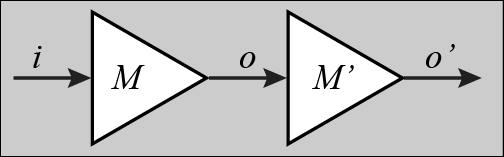

| Component | Contract | Inputs | Outputs | Assumptions | Guarantees |
| - | - | - | - | - | - |
| $M$ | `contract1` | `i` | `o` | `\|i\| <= 2` | `o <= i <= 2o + 2` |
| $M'$ | `contract2` | `o` | `o_p` | `-1 <= o <= 1/5` | `o_p <= o` |

We can use Pacti to obtain the contract of the system that assembles these two components as follows: 

In [1]:
from pacti.terms.polyhedra import PolyhedralContract

contract1 = PolyhedralContract.from_string(
    InputVars=["i"],
    OutputVars=["o"],
    assumptions=["|i| <= 2"],
    guarantees=["o - i <= 0", "i - 2o <= 2"])

contract2 = PolyhedralContract.from_string(
    InputVars=["o"],
    OutputVars=["o_p"],
    assumptions=["o <= 0.2", "-o <= 1"],
    guarantees=["o_p - o <= 0"])

system_contract = contract1.compose(contract2)
print(system_contract)

InVars: [i]
OutVars:[o_p]
A: [
  i <= 0.19999999999999996
  -0.5 i <= 0.0
]
G: [
  -i + o_p <= 0.0
]


Pacti gives us the specification of the system. Note that the resulting contract only involves the top-level input and output variables, having eliminated the intermediate variable, `o`.


## System diagnostics

Suppose that we want to build a system as shown in the figure above, with subsystem $M_1$ replacing $M$, as specified below:

| Component | Contract | Inputs | Outputs | Assumptions | Guarantees |
| - | - | - | - | - | - |
| $M_1$ | `contract1_n` | `i` | `o` | `\|i\| <= 2` | `\|o\| <= 3` |
| $M'$ | `contract2` | `o` | `o_p` | `-1 <= o <= 1/5` | `o_p <= o` |

The Pacti specification then becomes the following:

In [2]:
contract1_n = PolyhedralContract.from_string(
    InputVars=["i"],
    OutputVars=["o"],
    assumptions=["|i| <= 2"],
    guarantees=["|o| <= 3"])

new_system_contract = contract1_n.compose(contract2)

ValueError: The guarantees 
[
  |o| <= 3.0
]
were insufficient to abduce the assumptions 
[
  o <= 0.2
  -o <= 1.0
]
by eliminating the variables 
[<Var o>, <Var o_p>]

Pacti is unable to compute a system specification. In this case, this is due to the fact that our guarantee `\|o\| <= 3` for $M_1$ does not satisfy the assumptions of `contract2`.

## Specifications of missing subsystems

Now consider the situation shown in the following diagram:

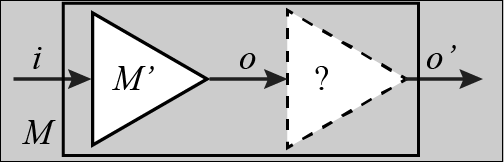

We wish to implement a system $M$ given an available subsystem $M'$ as described below.

| Component | Contract | Inputs | Outputs | Assumptions | Guarantees |
| - | - | - | - | - | - |
| $M$ | `contract_top_level` | `i` | `o_p` | `\|i\| <= 1` | `o_p = 2i + 1` |
| $M'$ | `contract_existing_subsystem` | `i` | `o` | `\|i\| <= 2` | `o = 2i` |

We use Pacti's quotient operation to obtain the specification of the missing subsystem corresponding to the question mark above so that the resulting object meets the specification `contract_top_level`. The following codifies this missing subsystem problem:

In [3]:
contract_top_level = PolyhedralContract.from_string(
    InputVars=["i"],
    OutputVars=["o_p"],
    assumptions=["|i| <= 1"],
    guarantees=["o_p - 2i = 1"])

contract_existing_subsystem = PolyhedralContract.from_string(
    InputVars=["i"],
    OutputVars=["o"],
    assumptions=["|i| <= 2"],
    guarantees=["o - 2i = 0"])

contract_missing_subsystem = contract_top_level.quotient(contract_existing_subsystem)
print(contract_missing_subsystem)

InVars: [o]
OutVars:[o_p]
A: [
  |o| <= 2.0
]
G: [
  -o + o_p = 1.0
]


Observe that Pacti tells us that the missing subsystem's specification has input `o` and output `o_p`. The resulting specification is guaranteed to implement the top-level system when composed with the contract of the existing subsystem. We can verify this:

In [4]:
# compose quotient 
new_system = contract_missing_subsystem.compose(contract_existing_subsystem)
print(new_system.refines(contract_top_level))

True


## Fusing viewpoints

Suppose that we have two specifications for a subsystem, corresponding to different viewpoints, as shown in the following table:

| Viewpoint | Contract | Inputs | Outputs | Assumptions | Guarantees |
| - | - | - | - | - | - |
| Functionality | `functionality_viewpoint` | `i` | `o` | `\|i\| <= 2` | `o = 2i + 1` |
| Power | `power_viewpoint` | `temp` | `P` | `temp <= 90` | `P <= 2.1` |

We can use contract merging to obtain a single specification for the subsystem:

In [5]:
functionality_viewpoint = PolyhedralContract.from_string(
    InputVars=["i"],
    OutputVars=["o"],
    assumptions=["|i| <= 2"],
    guarantees=["o - 2i = 1"])

power_viewpoint = PolyhedralContract.from_string(
    InputVars=["temp"],
    OutputVars=["P"],
    assumptions=["temp <= 90"],
    guarantees=["P <= 2.1"])

subsystem_contract = functionality_viewpoint.compose(power_viewpoint)
print(subsystem_contract)

InVars: [i, temp]
OutVars:[o, P]
A: [
  |i| <= 2.0
  temp <= 90.0
]
G: [
  -2.0 i + o = 1.0
  P <= 2.1
]


## To learn more

These examples illustrate some analysis tasks we can carry out with Pacti. The `case_studies` folder contains discussions of the application of Pacti in various design disciplines.

## References

<a id="ref1"></a> __[Benveniste et al. 2012](https://ieeexplore.ieee.org/document/8620676)__

Benveniste, A., Caillaud, B., Nickovic, D., Passerone, R., Raclet, J-B., Reinkemeier, P., Sangiovanni-Vincentelli, A., Damm, W., Henzinger, T. A., and Larsen, K. G. **Contracts for system design.** Foundations and Trends® in Electronic Design Automation 12, no. 2-3 (2018): 124-400.

<a id="ref2"></a> __[Incer 2022](https://escholarship.org/uc/item/1ts239xv)__

Incer, I. **The Algebra of Contracts**. PhD Thesis. University of California, Berkeley, 2022.